In [3]:
%config Autocompleter.use_jedi=False

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import OLS
import warnings

warnings.filterwarnings('ignore')

In [14]:
train_df = pd.read_csv('../data/raw/train.csv')
test_df = pd.read_csv('../data/raw/test.csv')

In [10]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# EDA

In [13]:
train_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


#### We can see 2 features have the missing values both in train and test dataset which needs to be handled:
    1. Item_Weight
    2. Outlet_Size
    
#### Irrelevant columns are present which can be removed:
    1. Item_Identifier
    2. Outlet_Identifer (Can be useful in grouping and getting some other informations)
    3. Outlet_Establishment_Year (can be useful to draw some informataion or to do feature engineering)

#### Some columns are categorical which needs to be encoded further:
    1. Item_Fat_Content
    2. Item_Type
    3. Outlet_Size
    4. Outlet_Location_Type
    5. Outlet_Type

<AxesSubplot:>

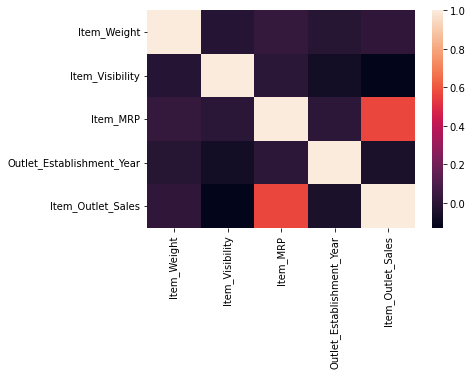

In [18]:
sns.heatmap(train_df.corr())

                        (Fig.- Correlation Heatmap for train data)

#### From this correlation heatmap it can be infered that there is no multicolinearity present.

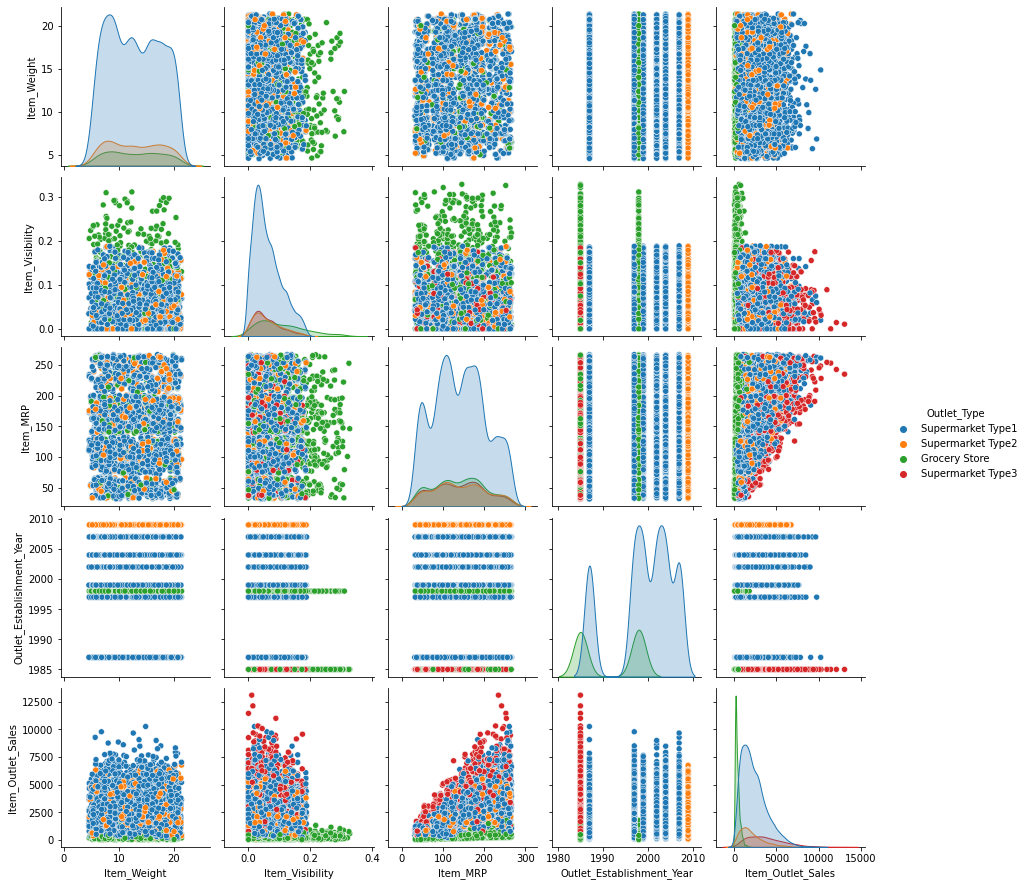

In [23]:
sns.pairplot(train_df,hue='Outlet_Type')

#### Some features are skewed which needs to be transformed:
    1. Item_Outlet_Sales (right skewed)
    2. Item_Visibility (right skewed)

#### From this diagram it can be inferred that:
    1. Overall Sales from all outlets  -> Supermarket Type1 > Supermarket Type3  > Grocery Store > Supermarket Type2
    2. Overall sales 
    3. Less sales from grocery store
    4. Outlet Establishments (earlier to later) => Supermarket Type3 -> Supermarket Type1 -> Grocery Store -> 
       Supermarket Type2
    

In [31]:
sales_skewness = train_df['Item_Outlet_Sales'].skew()
visibility_skewness = train_df['Item_Visibility'].skew()
print('Skewness for Item_Outlet_Sales is {} and for Item_Visibility is {}'.format(sales_skewness,visibility_skewness))

Skewness for Item_Outlet_Sales is 1.1775306028542796 and for Item_Visibility is 1.1670905496918396


#### From this it seems like these 2 features are highly skewed (>1), which can lead to unreliable results. So we need to transform it using either of these methods:
    1. Log transform (most preferred) -- We are going to use this over here
    2. Sqrt transform (generally less preferred)
    3. box-cox transform

In [34]:
# Applying log transform to both skewed feature
train_df['Log_Item_Visibility'] = np.log(train_df['Item_Visibility'])
train_df['Log_Item_Outlet_Sales'] = np.log(train_df['Item_Outlet_Sales'])

train_df.drop(columns=['Item_Visibility','Item_Outlet_Sales'],axis=1,inplace=True)

c:\python39\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


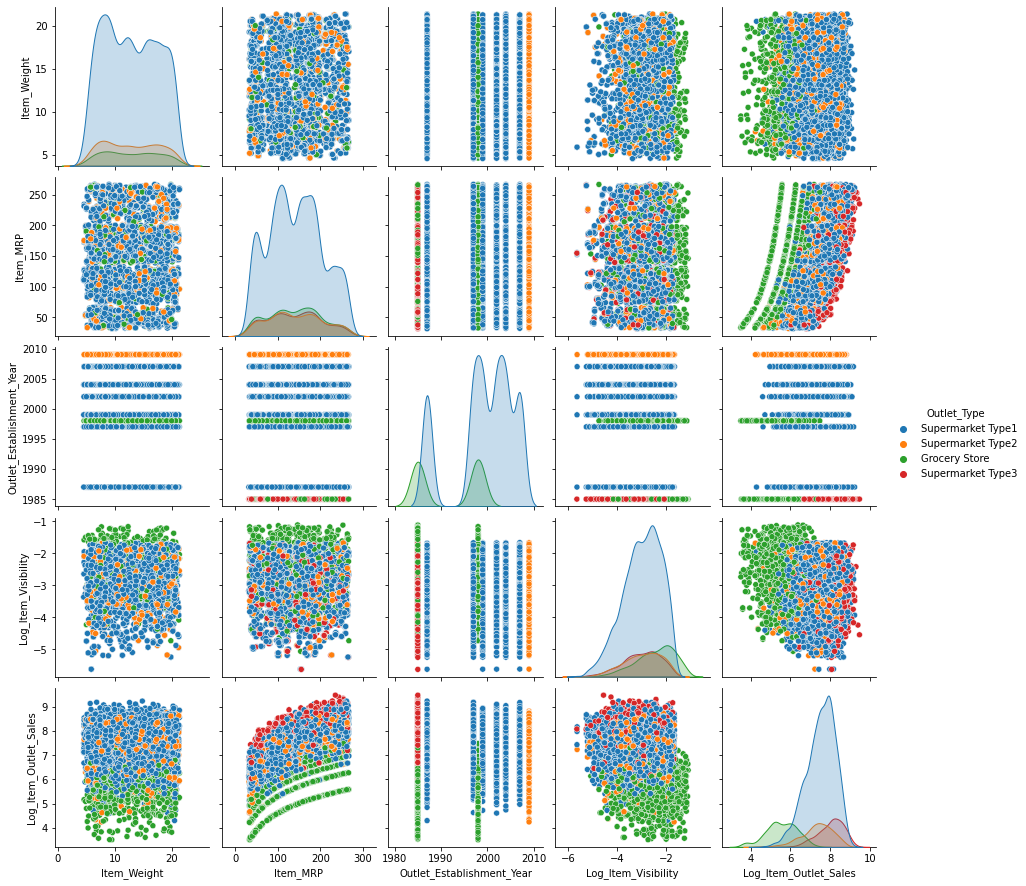

In [37]:
sns.pairplot(train_df,hue='Outlet_Type')

#### After transforming the skewed data it can be inferred that:
    1. As Item MRP is increasing sales is also increasing